헤어 모델 트레이닝 코드: https://github.com/thangtran480/hair-segmentation 

Here are the modifications I made:
*   I added some functionality that allows for **retraining** using a saved .h5 model.
*   I added **4k more images** & masks to the dataset.
*   I trained a new model with **better accuracy** and **smaller loss**.

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

### Colab에서 cv2.imshow() 가 작동안할때 사용

In [2]:
def imShow(image):
  import matplotlib.pyplot as plt
  %matplotlib inline

  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

### Use the saved model to create the hair mask.

In [3]:
def predict(image, height=224, width=224):
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    """Preprocess the input image before prediction"""
    im = im / 255
    im = cv2.resize(im, (height, width))
    im = im.reshape((1,) + im.shape)
    
    pred = model.predict(im)
    
    mask = pred.reshape((224, 224))

    return mask

In [4]:
model = keras.models.load_model('checkpoints/hairnet_matting_30.hdf5')   # Load saved model
#model.summary()

In [5]:
def Change_hair_color(img, color):
    global thresh

    image = cv2.imread(img)
    mask = predict(image)
    
    kernel = np.ones((1,1), np.uint8)
    mask = cv2.erode(mask, kernel, iterations = 1)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    thresh = 0.60  # Threshold used on mask pixels
    

    """Create 3 copies of the mask, one for each color channel"""
    blue_mask = mask.copy()
    blue_mask[mask > thresh] = color[0]
    blue_mask[mask <= thresh] = 0

    green_mask = mask.copy()
    green_mask[mask > thresh] = color[1]
    green_mask[mask <= thresh] = 0

    red_mask = mask.copy()
    red_mask[mask > thresh] = color[2]
    red_mask[mask <= thresh] = 0

    blue_mask = cv2.resize(blue_mask, (image.shape[1], image.shape[0]))
    green_mask = cv2.resize(green_mask, (image.shape[1], image.shape[0]))
    red_mask = cv2.resize(red_mask, (image.shape[1], image.shape[0]))

    """Create an rgb mask to superimpose on the image"""
    mask_n = np.zeros_like(image)
    mask_n[:, :, 0] = blue_mask
    mask_n[:, :, 1] = green_mask
    mask_n[:, :, 2] = red_mask

    alpha = 0.90
    beta = (1.0 - alpha)*3
    out = cv2.addWeighted(image, alpha, mask_n, beta, 0.0)

    name = 'test/results/colored.jpg'
    imShow(out)
    cv2.imwrite(name, out)

### Select a bgr color and an image.

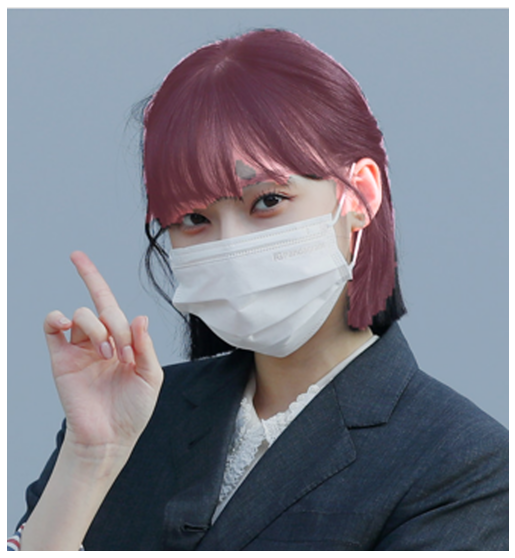

In [6]:
img_path = 'test/20211203_024818.png'  # Use images 1, 2, 3 or even upload a different image to test on it
color = [124, 100, 250]  # Color to be used on hair
Change_hair_color(img_path, color)

## 비디오로 출력

In [7]:
def onChange(pos):
    pass

def Change_hair_color_video(image, color):

    mask = predict(image)  
    #thresh = 0.7  # Threshold used on mask pixels
    
    kernel = np.ones((1,1), np.uint8)
    mask = cv2.erode(mask, kernel, iterations = 1)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    """Create 3 copies of the mask, one for each color channel"""
    blue_mask = mask.copy()
    blue_mask[mask > thresh] = color[0]
    blue_mask[mask <= thresh] = 0

    green_mask = mask.copy()
    green_mask[mask > thresh] = color[1]
    green_mask[mask <= thresh] = 0

    red_mask = mask.copy()
    red_mask[mask > thresh] = color[2]
    red_mask[mask <= thresh] = 0

    blue_mask = cv2.resize(blue_mask, (image.shape[1], image.shape[0]))
    green_mask = cv2.resize(green_mask, (image.shape[1], image.shape[0]))
    red_mask = cv2.resize(red_mask, (image.shape[1], image.shape[0]))

    """Create an rgb mask to superimpose on the image"""
    mask_n = np.zeros_like(image)
    mask_n[:, :, 0] = blue_mask
    mask_n[:, :, 1] = green_mask
    mask_n[:, :, 2] = red_mask

    alpha = 0.90
    #beta = (1.0 - alpha)*3
    out = cv2.addWeighted(image, alpha, mask_n, beta, 0.0)
    
    return out

In [8]:
cap = cv2.VideoCapture(0)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

cv2.namedWindow('img_result')
cv2.createTrackbar('threshold', 'img_result', 0, 100, onChange)
cv2.setTrackbarPos('threshold', 'img_result', 50)

cv2.createTrackbar('beta', 'img_result', 0, 50, onChange)
cv2.setTrackbarPos('beta', 'img_result', 25)

cv2.createTrackbar('R', 'img_result', 0, 255, onChange)
cv2.createTrackbar('G', 'img_result', 0, 255, onChange)
cv2.createTrackbar('B', 'img_result', 0, 255, onChange)


while(cap.isOpened()):
  
    thresh = cv2.getTrackbarPos('threshold', 'img_result')
    thresh = thresh / 100
    
    beta = cv2.getTrackbarPos('beta', 'img_result')
    beta = beta / 100
    
    color[2] = cv2.getTrackbarPos('R', 'img_result')
    color[1] = cv2.getTrackbarPos('G', 'img_result')
    color[0] = cv2.getTrackbarPos('B', 'img_result')
    
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    
    rst = Change_hair_color_video(frame, color)
    
    cv2.imshow('img_result', rst)
    
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
cv2.destroyAllWindows()

## 여기는 이미지출력

In [9]:
img = cv2.imread('test/20211126_155331.png')
dst = cv2.resize(img, (700,800))

cv2.namedWindow('img_result')
cv2.createTrackbar('threshold', 'img_result', 0, 100, onChange)
cv2.setTrackbarPos('threshold', 'img_result', 50)

cv2.createTrackbar('beta', 'img_result', 0, 50, onChange)
cv2.setTrackbarPos('beta', 'img_result', 25)

cv2.createTrackbar('R', 'img_result', 0, 255, onChange)
cv2.createTrackbar('G', 'img_result', 0, 255, onChange)
cv2.createTrackbar('B', 'img_result', 0, 255, onChange)

while(True):
    
    thresh = cv2.getTrackbarPos('threshold', 'img_result')
    thresh = thresh / 100
    
    beta = cv2.getTrackbarPos('beta', 'img_result')
    beta = beta / 100
    
    color[2] = cv2.getTrackbarPos('R', 'img_result')
    color[1] = cv2.getTrackbarPos('G', 'img_result')
    color[0] = cv2.getTrackbarPos('B', 'img_result')

    rst = Change_hair_color_video(dst, color)
    
    cv2.imshow('img_result', rst)
    
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cv2.destroyAllWindows()

###### 여긴안써!

In [ ]:
'''
cap = cv2.VideoCapture(0)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

while(cap.isOpened()):
    ret, frame = cap.read()
    
    frame = cv2.flip(frame, 1)
    
    rst = Change_hair_color_video(frame, color)
    
    #cv2.imshow('input', frame)
    cv2.imshow('result', rst)
    
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
cv2.destroyAllWindows()
'''

In [13]:
'''
cap = cv2.VideoCapture(0)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('test.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, (frame_width,frame_height))

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    out.write(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
out.release()
cv2.destroyAllWindows()

'''

In [ ]:
'''
cap = cv2.VideoCapture('test.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('vid_out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, (frame_width,frame_height))
color = (255, 0, 0)

while(True):
    ret, frame = cap.read()

    if ret == True:
        dst = Change_hair_color_video(frame, color)
        out.write(dst)  # This saves the output video as "vid_out.mp4" *Use VLC to open it*
        #imShow(dst)    # Uncomment this line to show the the effect on video in real-time

    else:
        break

cap.release()
out.release()


cv2.namedWindow('img_result')
cv2.createTrackbar('thresh', 'img_result', 0, 1, nothing)
cv2.setTrackbarPos('thresh', 'img_result', 0.65)

'''